<a href="https://colab.research.google.com/github/VadimFarutin/deep-unsupervised-learning/blob/hw02/hw02_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW02

## 2 High-dimensional data

### Imports and Data

In [0]:
%%capture
!pip install graphql-core==2.0
!pip install wandb -q

In [6]:
import wandb
!wandb login

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: 2
wandb: You chose 'Use an existing W&B account'
wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 8c292ca69e334e8a562d4a4c6570fdd3ad29c825
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
from collections import defaultdict
from tqdm import tnrange, tqdm_notebook
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
import random
import pickle

import torch
import torch.nn as nn
from torch.nn.modules import loss
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.distributions import Normal, Uniform, MultivariateNormal

In [0]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')
print(DEVICE)

cuda


In [0]:
EPS = 1e-5
MAX_VALUE = 5

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def read_data():
    path = 'drive/My Drive/hw2_q2.pkl'

    with open(path, 'rb') as file:
        dataset = pickle.load(file)
    
    return dataset['train'].transpose(0, 3, 1, 2), dataset['test'].transpose(0, 3, 1, 2)


In [0]:
train, val = read_data()

In [14]:
print(train.shape, val.shape)

(20000, 3, 32, 32) (6838, 3, 32, 32)


### Common code

In [0]:
def MyNLLLoss(y):
    # return -torch.mean(torch.log(y + EPS)) / 2
    return -torch.mean(y) / 2

In [0]:
from torch import autograd

def fit(model, train, val, optimizer, loss_function, epoch_cnt, batch_size):
    train_loader = torch.utils.data.DataLoader(torch.from_numpy(train), batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(torch.from_numpy(val), batch_size=batch_size)
    train_loss_values = []
    val_loss_values = []
            
    with autograd.detect_anomaly():
        for epoch in tnrange(epoch_cnt, desc='Epoch'):
            model.train()
            for batch_data in train_loader:
                x = batch_data.float().to(DEVICE)
                optimizer.zero_grad()
                output = model(x)
                # print("..............................passed forward..........................")
                loss = loss_function(output)
                train_loss_values.append(loss.item())
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 5)
                optimizer.step()
                # print("..............................passed step..........................")

                wandb.log({"Train Loss": loss.item()})

            loss_values = []
            model.eval()
            for batch_data in val_loader:
                x = batch_data.float().to(DEVICE)
                output = model(x)
                loss = loss_function(output)
                loss_values.append(loss.item())
            val_loss_values.append(np.mean(np.array(loss_values)))

            wandb.log({"Validation Loss": val_loss_values[-1]})
    
    return train_loss_values, val_loss_values 


In [0]:
def plot_loss_values(train_loss_values, val_loss_values):
    plt.plot(np.arange(len(train_loss_values)), train_loss_values, color='blue', label='train')
    plt.plot(np.arange(0, len(train_loss_values), len(train_loss_values) / config.epochs), val_loss_values, color='red', label='validation')
    plt.legend()
    plt.title("Loss values")
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()

### RealNVP

In [0]:
class ResBlock(nn.Module):
    def __init__(self, channels, type):
        super(ResBlock, self).__init__()

        if type == 'A':
            self.layers = nn.Sequential(nn.Conv2d(channels, channels, kernel_size=(1, 1), stride=(1, 1), padding=0),
                                        nn.BatchNorm2d(channels),
                                        nn.ReLU(),
                                        nn.Conv2d(channels, channels, kernel_size=(3, 3), stride=(1, 1), padding=1),
                                        nn.BatchNorm2d(channels))        
        else:
            self.layers = nn.Sequential(nn.ReLU(),
                                        nn.Conv2d(channels, channels, kernel_size=(1,1), stride=(1, 1), padding=0))
        
    def forward(self, x):
        out = self.layers(x)
        return out

    def __call__(self, x):
        return self.forward(x)

In [0]:
class Resnet(nn.Module):
    def __init__(self, in_channels, hidden_size, n_blocks):
        super(Resnet, self).__init__()
        out_channels = in_channels * 2

        self.conv1 = nn.Conv2d(in_channels, hidden_size, kernel_size=(3, 3), stride=(1, 1), padding=2)

        self.res_blocks_a = torch.nn.ModuleList([ResBlock(hidden_size, 'A')
                                                 for _ in range(n_blocks)])
        self.res_blocks_b = torch.nn.ModuleList([ResBlock(hidden_size, 'B')
                                                 for _ in range(n_blocks)])

        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(hidden_size, out_channels, kernel_size=(3, 3), stride=(1, 1))
    
    def forward(self, x):
        h = x
        h = self.conv1(h)

        for res_block_a, res_block_b in zip(self.res_blocks_a, self.res_blocks_b):
            _h = res_block_a(h)
            h = res_block_b(_h)
            h = h + _h
            h = self.relu(h)

        h = self.conv2(h)

        return h

    def __call__(self, x):
        return self.forward(x)

In [0]:
class AffineCoupling(nn.Module):
    def __init__(self, mask, in_channels):
        super(AffineCoupling, self).__init__()
        self.mask = mask
        # self.resnet = Resnet(in_channels, hidden_size=256, n_blocks=8)
        self.resnet = Resnet(in_channels, hidden_size=64, n_blocks=1)
    
    def forward(self, x):
        y1 = self.mask * x
        log_s, t = torch.chunk(self.resnet(y1), 2, dim=1)
        log_det = torch.sum(log_s.view(y1.shape[0], -1), dim=1)

        return log_det

    def latent(self, x):
        y1 = self.mask * x
        log_s, t = torch.chunk(self.resnet(y1), 2, dim=1)
        y2 = (1 - self.mask) * torch.exp(log_s) * (x + t)

        return y1 + y2

    def inverse(self, y):
        x1 = self.mask * y
        log_s, t = torch.chunk(self.resnet(x1), 2, dim=1)
        x2 = (1 - self.mask) * y * torch.exp(-log_s) - t

        return x1 + x2
        
    def __call__(self, x):
        return self.forward(x)

In [0]:
class ActNorm(nn.Module):
    def __init__(self, in_channels, size):
        super(ActNorm, self).__init__()
        
        self.w = nn.Parameter(torch.ones([1, in_channels, size[0], size[1]]))
        self.b = nn.Parameter(torch.zeros([1, in_channels, size[0], size[1]]))
        
    def forward(self, x):
        logdet = torch.log(self.w.abs() + EPS).flatten(1).sum(dim=1)
        return logdet
        # return torch.zeros(x.shape[0]).to(DEVICE)

    def latent(self, x):
        y = x * self.w + self.b
        return y
        # return x

    def inverse(self, y):
        x = (y - self.b) / self.w
        return x
        # return y

    def __call__(self, x):
        return self.forward(x)

In [0]:
class Preprocess(nn.Module):
    def __init__(self, alpha):
        super(Preprocess, self).__init__()
        
        self.alpha = alpha
        
    def forward(self, x):
        y = self.alpha + (1.0 - self.alpha) * x / 4.0
        diag = (torch.ones_like(x) * (1.0 - self.alpha) / 4.0).flatten(start_dim=1)
        logdet = torch.log(diag.abs()).sum(dim=1)
        diag = (1.0 / y + 1.0 / (1.0 - y)).abs().flatten(start_dim=1)
        logdet = logdet + torch.log(diag + EPS).sum(dim=1)
        return logdet

    def latent(self, x):
        y = self.alpha + (1.0 - self.alpha) * x / 4.0
        y = torch.log(y) - torch.log(1.0 - y)
        return y

    def inverse(self, y):
        x = torch.exp(y)
        x = x / (x + 1.0)
        x = 4.0 * (x - self.alpha) / (1.0 - self.alpha)
        return x

    def __call__(self, x):
        return self.forward(x)

In [0]:
class MyRealNVP(nn.Module):
    def __init__(self, in_channels, size):
        super(MyRealNVP, self).__init__()

        self.preprocess = Preprocess(0.05)

        mask = self.checkerboard_mask(in_channels, size)
        self.couplings1 = nn.Sequential(AffineCoupling(mask, in_channels),
                                        ActNorm(in_channels, size),
                                        AffineCoupling(1 - mask, in_channels),
                                        ActNorm(in_channels, size),
                                        AffineCoupling(mask, in_channels),
                                        ActNorm(in_channels, size),
                                        AffineCoupling(1 - mask, in_channels),
                                        ActNorm(in_channels, size)
                                        )

        size = size[0] // 2, size[1] // 2
        in_channels = in_channels * 4
        mask = self.channel_split_mask(in_channels, size)
        self.couplings2 = nn.Sequential(AffineCoupling(mask, in_channels),
                                        ActNorm(in_channels, size),
                                        AffineCoupling(1 - mask, in_channels),
                                        ActNorm(in_channels, size),
                                        AffineCoupling(mask, in_channels),
                                        ActNorm(in_channels, size))

        mask = self.checkerboard_mask(in_channels, size)
        self.couplings3 = nn.Sequential(AffineCoupling(mask, in_channels),
                                        ActNorm(in_channels, size),
                                        AffineCoupling(1 - mask, in_channels),
                                        ActNorm(in_channels, size),
                                        AffineCoupling(mask, in_channels),
                                        ActNorm(in_channels, size))

        size = size[0] // 2, size[1] // 2
        in_channels = in_channels * 4
        mask = self.channel_split_mask(in_channels, size)
        self.couplings4 = nn.Sequential(AffineCoupling(mask, in_channels),
                                        ActNorm(in_channels, size),
                                        AffineCoupling(1 - mask, in_channels),
                                        ActNorm(in_channels, size),
                                        AffineCoupling(mask, in_channels),
                                        ActNorm(in_channels, size))

        mask = self.checkerboard_mask(in_channels, size)
        self.couplings5 = nn.Sequential(AffineCoupling(mask, in_channels),
                                        ActNorm(in_channels, size),
                                        AffineCoupling(1 - mask, in_channels),
                                        ActNorm(in_channels, size),
                                        AffineCoupling(mask, in_channels),
                                        ActNorm(in_channels, size))

    def checkerboard_mask(self, in_channels, size):
        black = np.ones([1, in_channels, size[0], size[1]], dtype=np.bool)
        white = np.ones([1, in_channels, size[0], size[1]], dtype=np.bool)
        black[:, :, np.arange(1, size[0], 2), :] = False 
        white[:, :, :, np.arange(0, size[1], 2)] = False
        mask = torch.tensor(black ^ white, dtype=torch.float32).to(DEVICE)

        return mask

    def channel_split_mask(self, in_channels, size):
        mask = torch.zeros([1, in_channels, size[0], size[1]], dtype=torch.float32).to(DEVICE)
        channels_i = np.arange(0, in_channels // 4) * 4
        channels_i = np.stack((channels_i, channels_i + 1), axis=1).reshape(-1)
        mask[:, channels_i, :, :] = 1.0

        return mask
    
    def squeeze(self, x):
        b, c, h, w = x.shape
        return F.unfold(x, (2, 2), stride=2).reshape(b, 4 * c, h // 2, w // 2)

    def unsqueeze(self, x):
        b, c, h, w = x.shape
        return F.fold(x.reshape(b, c, -1), (h * 2, w * 2), (2, 2), stride=2)
            
    def forward(self, x):
        # logdet = torch.zeros(x.shape[0]).to(DEVICE)
        # y = x
        logdet = self.preprocess(x)
        y = self.preprocess.latent(x)
        # print(torch.sum(torch.isnan(y)))

        for layer in self.couplings1:
            logdet += layer(y)
            y = layer.latent(y)

        y = self.squeeze(y)
        
        for layer in self.couplings2:
            logdet += layer(y)
            y = layer.latent(y)
        for layer in self.couplings3:
            logdet += layer(y)
            y = layer.latent(y)

        y = self.squeeze(y)
        
        for layer in self.couplings4:
            logdet += layer(y)
            y = layer.latent(y)
        for layer in self.couplings5:
            logdet += layer(y)
            y = layer.latent(y)
        
        logdet = torch.exp(torch.clamp(logdet, min=-MAX_VALUE, max=MAX_VALUE))

        return logdet
        
    def latent(self, x):
        # y = x
        y = self.preprocess.latent(x)
        
        for layer in self.couplings1:
            y = layer.latent(y)

        y = self.squeeze(y)
        
        for layer in self.couplings2:
            y = layer.latent(y)
        for layer in self.couplings3:
            y = layer.latent(y)

        y = self.squeeze(y)
        
        for layer in self.couplings4:
            y = layer.latent(y)
        for layer in self.couplings5:
            y = layer.latent(y)

        y = self.unsqueeze(y)
        y = self.unsqueeze(y)
        
        return y

    def inverse(self, y):
        x = y
        x = self.squeeze(x)
        x = self.squeeze(x)
        
        for layer in reversed(self.couplings5):
            x = layer.inverse(x)
        for layer in reversed(self.couplings4):
            x = layer.inverse(x)
            
        x = self.unsqueeze(x)
        
        for layer in reversed(self.couplings3):
            x = layer.inverse(x)
        for layer in reversed(self.couplings2):
            x = layer.inverse(x)
            
        x = self.unsqueeze(x)
        
        for layer in reversed(self.couplings1):
            x = layer.inverse(x)
            
        x = self.preprocess.latent(x)

        return x

    def __call__(self, x):
        return self.forward(x)

In [178]:
wandb.init(entity="vadim-farutin", project="HSE-DUL-HW02-3")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release

config = wandb.config
config.lr = 5e-4
config.batch_size = 64
config.epochs = 2

In [0]:
# from torchsummary import summary
# summary(model, (3, 32, 32))

In [0]:
channels, size = 3, (32, 32)
model = MyRealNVP(channels, size).float().to(DEVICE)
loss_function = MyNLLLoss
optimizer = optim.Adam(model.parameters(), lr=config.lr)

In [0]:
train_loss_values, val_loss_values =\
    fit(model, train, val, optimizer, loss_function, config.epochs, config.batch_size)

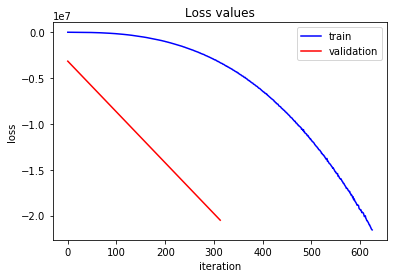

In [110]:
plot_loss_values(train_loss_values, val_loss_values)